
# Computer Vision WS-24/25 Assignment 2.4: Feature Extration and Matching

## Part 0.1: Setting Up the Environment
Before we tackle feature extration and matching, we need to setup our working environment. This includes a few lines of code to setup the jupyter environment and to verify our python environment. We include all the static python libraries that we will use during this assignment. If you feel like importing additional libraries for visualization or debugging purposes, please feel free to add them here!

In [1]:
%load_ext autoreload
%autoreload 3

In [ ]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

## Part 0.2: Load images
For this assignment, we provide two images under the data file. The task is to extract features for both images using cv2 feature extractor and establish the matches between two images. 

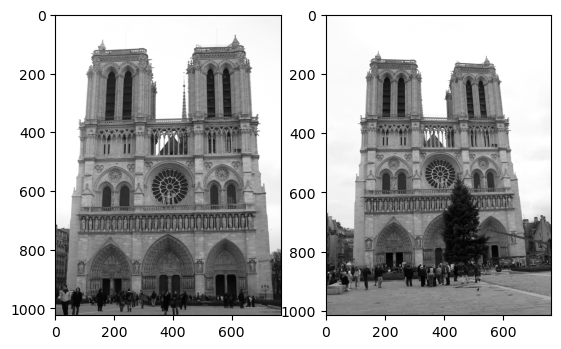

In [79]:
img1 = cv2.imread("./data/NotreDame1.jpg")
color1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
gray1 = cv2.cvtColor(color1, cv2.COLOR_RGB2GRAY)

img2 = cv2.imread("./data/NotreDame2.jpg")
color2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
gray2 = cv2.cvtColor(color2, cv2.COLOR_RGB2GRAY)

plt.subplot(1, 2, 1)
plt.imshow(gray1, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(gray2, cmap='gray')
plt.show()

## Part 1: Keypoints Detection

### Part 1.0: Use SIFT as keypoint detector
Please use Scale Invariant Feature Transform (SIFT) algorithm from cv2

Number of SIFT keypoints:  6236


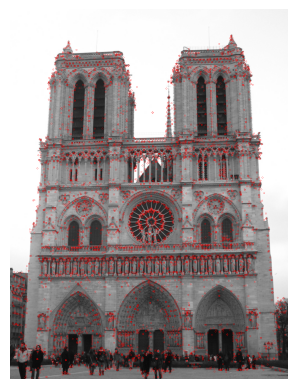

In [ ]:
sift = cv2.SIFT_create()

sift_kp = sift.detect(gray1,None)
print("Number of SIFT keypoints: ", len(sift_kp))


### Part 1.1: Visualize Keypoints
Please implement the function `visualize_keypoint()`. 
Note: Preprocess the keypoints in cv2 format to an array of keypoint coordinate using function `convert_kp_to_coord()`.

In [ ]:
def visualize_keypoint(keypoints, image):
    if len(image.shape) == 2:
        rgb_image = image.copy()
        rgb_image = rgb_image[..., None].repeat(3, -1)

    plt.imshow(rgb_image)
    fig = plt.gcf()
    ax = fig.gca()
    for kp in keypoints:
        ax.add_patch(plt.Circle(kp, 0.2, color="r"))

    plt.imshow(rgb_image)
    plt.axis("off")
    plt.show()


def convert_kp_to_coord(keypoints):
    coord_list = []
    for kp in keypoints:
        coord_list.append(kp.pt)

    return np.array(coord_list)

In [ ]:
sift_kp_coord = convert_kp_to_coord(sift_kp)
visualize_keypoint(sift_kp_coord, gray1)

### Part 1.2: Use FAST as keypoint detector
Please use the Features from Acelerated Segment Test (FAST) algorithm from cv2 to detect keypoints; Visualize the keypoints using the `visualize_keypoint()` function

Number of ORB keypoints:  500


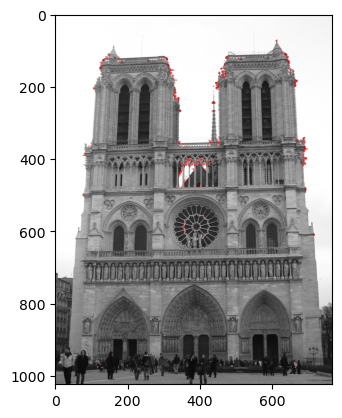

In [18]:
orb = cv2.ORB_create()

orb_kp = orb.detect(gray1, None)
print("Number of ORB keypoints: ", len(orb_kp))
orb_kp_coord = convert_kp_to_coord(orb_kp)
visualize_keypoint(orb_kp_coord, gray1)

### Part 1.3: Use Harris Corner as the keypoint detector
Please use the Harris Corner Detection (FAST) algorithm from cv2 to detect keypoints; Visualize the keypoints using the `visualize_keypoint()` function

Number of Harris keypoints:  1565


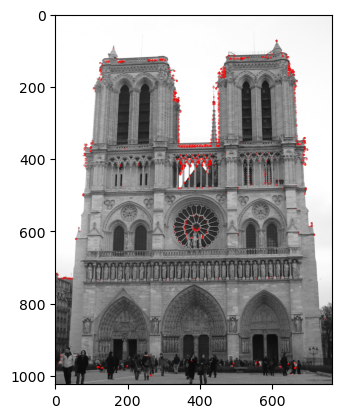

In [24]:
# Detect keypoint using Harris corner detection
dst = cv2.cornerHarris(gray1, 2, 3, 0.04)
threshold = 0.01 * dst.max()
harris_kp_coord = np.stack((dst > threshold).nonzero(), axis=1)
# swap x,y coordinate, since the harris corner detection return x coordinate in width, y coordinate in height
harris_kp_coord = harris_kp_coord[:,[1,0]]
print("Number of Harris keypoints: ", len(harris_kp_coord))

visualize_keypoint(harris_kp_coord, gray1)

# Part 2.0: Compute descriptors 
Use SIFT and ORB to compute the descriptors for detected SIFT and ORB keypoints from the first image

In [46]:
_, hog_des1 = sift.compute(gray1, sift_kp)
_, breif_des1 = orb.compute(gray1, orb_kp)

print("SIFT descriptor shape: ", hog_des1.shape)
print("ORB descriptor shape: ", breif_des1.shape)

SIFT descriptor shape:  (6236, 128)
ORB descriptor shape:  (500, 32)


Now, apply the SIFT and ORB to detect keypoints and extract features to the second image

In [47]:
sift_kp2 = sift.detect(gray2,None)
sift_kp_coord2 = convert_kp_to_coord(sift_kp2)
_, hog_des2 = sift.compute(gray2, sift_kp2)

orb_kp2 = orb.detect(gray2, None)
orb_kp_coord2 = convert_kp_to_coord(orb_kp2)
_, breif_des2 = orb.compute(gray2, orb_kp2)

print("SIFT descriptor shape: ", hog_des2.shape)
print("ORB descriptor shape: ", breif_des2.shape)

SIFT descriptor shape:  (5115, 128)
ORB descriptor shape:  (500, 32)


## Part 3: Descriptor Matching

### Part 3.0: Implement the brute-force descriptor matcher with Lowe tests and cross consistency check
Please implement the `compute_distance_matrix()`, `cycle_consistency_match()`, `lowe_match` in matcher.py file.
When computing the distance matrix, you should choose a correct distance measurement based on the descriptor data dtype. For example, norm `L2` is good for HOG features. For binary string based descriptors like ORB, norm `hamming` should be used.


### Part 3.1: Implement the plot_matches function to visualize the matches between two images

In [39]:
from matcher import cycle_consistency_match, lowe_match

def plot_matches(kp1, kp2, matches, image1, image2):
    new_shape1 = list(image1.shape)
    new_shape2 = list(image2.shape)

    if image1.shape[0] < image2.shape[0]:
        new_shape1[0] = image2.shape[0]
    elif image1.shape[0] > image2.shape[0]:
        new_shape2[0] = image1.shape[0]

    if image1.shape[1] < image2.shape[1]:
        new_shape1[1] = image2.shape[1]
    elif image1.shape[1] > image2.shape[1]:
        new_shape2[1] = image1.shape[1]

    if new_shape1 != image1.shape:
        new_image1 = np.zeros(new_shape1, dtype=image1.dtype)
        new_image1[: image1.shape[0], : image1.shape[1]] = image1
        image1 = new_image1

    if new_shape2 != image2.shape:
        new_image2 = np.zeros(new_shape2, dtype=image2.dtype)
        new_image2[: image2.shape[0], : image2.shape[1]] = image2
        image2 = new_image2

    offset = np.array(image1.shape)
    # align image horizontal
    image = np.concatenate([image1, image2], axis=1)
    offset[0] = 0

    fig, ax = plt.subplots()
    ax.imshow(image, cmap="gray")
    ax.axis((0, image1.shape[1] + offset[1], image2.shape[0] + offset[0], 0))

    rng = np.random.default_rng()

    for i in range(matches.shape[0]):
        idx0 = matches[i, 0]
        idx1 = matches[i, 1]

        color = rng.random(3)

        ax.plot(
            (kp1[idx0, 1], kp2[idx1, 1] + offset[1]),
            (kp1[idx0, 0], kp2[idx1, 0] + offset[0]),
            "-",
            color=color,
        )

    plt.show()



408.1507


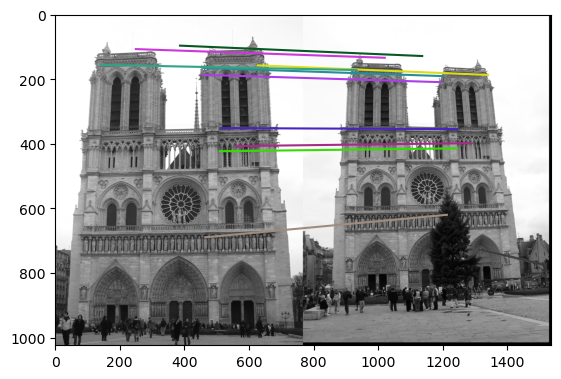

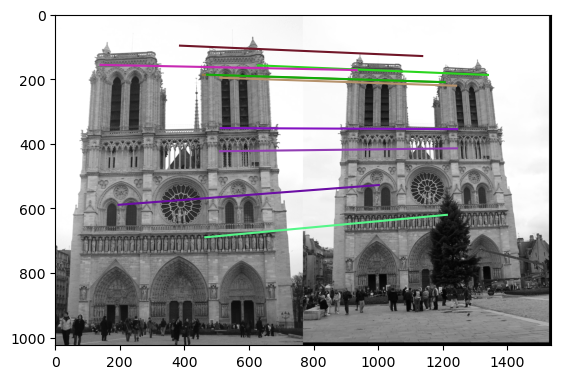

In [80]:
hog_matches1 = cycle_consistency_match(descriptors1=hog_des1, descriptors2=hog_des2)
hog_matches2 = lowe_match(
    descriptors1=hog_des1, descriptors2=hog_des2, threshold=237, ratio=0.5
)

plot_matches(sift_kp_coord, sift_kp_coord2, hog_matches1[:10], gray1, gray2)
plot_matches(sift_kp_coord, sift_kp_coord2, hog_matches2[:10], gray1, gray2)

96
Number of matches using cycle consistency match:  146
Number of matches using Lowe's ratio test:  28


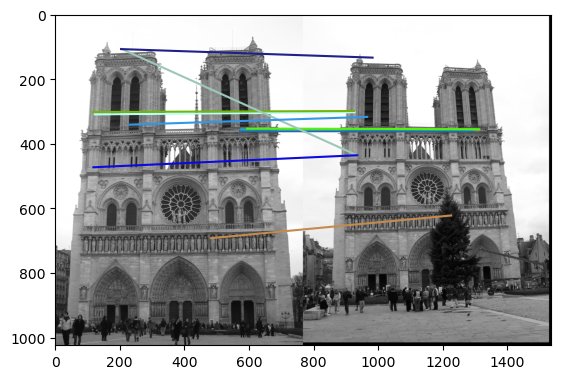

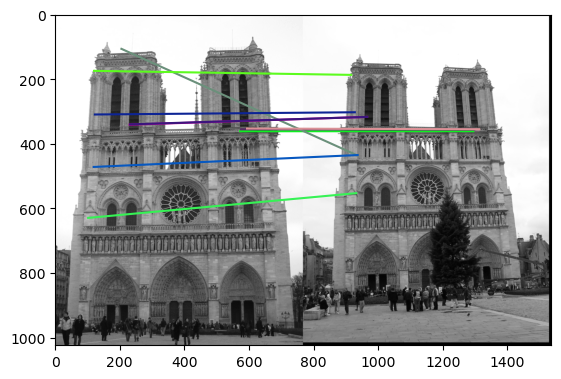

In [69]:
orb_matches1 = cycle_consistency_match(
    descriptors1=breif_des1, descriptors2=breif_des2, norm="hamming"
)
orb_matches2 = lowe_match(
    descriptors1=breif_des1,
    descriptors2=breif_des2,
    threshold=50,
    ratio=0.8,
    norm="hamming",
)

print("Number of matches using cycle consistency match: ", len(orb_matches1))
print("Number of matches using Lowe's ratio test: ", len(orb_matches2))

plot_matches(orb_kp_coord, orb_kp_coord2, orb_matches1[:10], gray1, gray2)
plot_matches(orb_kp_coord, orb_kp_coord2, orb_matches2[:10], gray1, gray2)